In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd

C:\Users\cuita\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# load and transfor training data from standard source
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize image to [-1, 1]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# dataloader for batch training (mini-batch gradient descent)
batch_size=32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
# 10 classes in total
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# load test data (note that the data has been transformed already)
test_images = torch.load('test_image.pt')

torch.Size([8, 3, 32, 32]) tensor([1, 1, 1, 6, 8, 9, 8, 5])


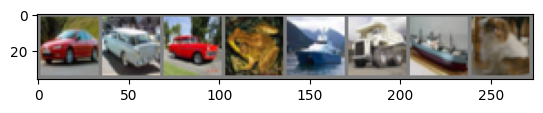

car   car   car   frog  ship  truck ship  dog  


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get a random batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape, labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
import optuna
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def objective(trial):
    # Define hyperparameters using the trial object
    n_filters_conv1 = trial.suggest_int('n_filters_conv1', 16, 128)
    n_filters_conv2 = trial.suggest_int('n_filters_conv2', 16, 128)
    fc1_units = trial.suggest_int('fc1_units', 16, 128)
    fc2_units = trial.suggest_int('fc2_units', 16, 128)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    
    model = CNN(n_filters_conv1, n_filters_conv2, fc1_units, fc2_units)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training the model
    for epoch in range(10): # train for 10 epochs as an example
        for data, target in trainloader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
    # Evaluating the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in testloader:
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = correct / total
    return accuracy

In [10]:
# YOUR TASK: set the hyperparameters of CNN
class CNN(nn.Module):
    def __init__(self, n_filters_conv1=2, n_filters_conv2=2, fc1_units=64, fc2_units=32):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_filters_conv1, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_filters_conv1, n_filters_conv2, 5) 
        self.fc1 = nn.Linear(n_filters_conv2 * 5 * 5, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [11]:
# Start the Optuna study
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
study = optuna.create_study(direction='maximize') # maximize accuracy
study.optimize(objective, n_trials=10) # search across 50 different hyperparameter combinations

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-10-24 19:57:26,344] A new study created in memory with name: no-name-bad0b8b0-d446-4139-9060-1eb598eb0c1e
C:\Users\cuita\AppData\Local\Temp\ipykernel_8452\4255863716.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[W 2023-10-24 19:57:58,042] Trial 0 failed with parameters: {'n_filters_conv1': 70, 'n_filters_conv2': 30, 'fc1_units': 107, 'fc2_units': 103, 'lr': 3.2539260863852656e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\cuita\AppData\Local\Programs\Python\Python38\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\cuita\AppData\Local\Temp\ipykernel_8452\4255863716.py", line 15, in objective
    for data, target in trainloader:
  File

KeyboardInterrupt: 

In [24]:
#######################################GPU################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
class CNN(nn.Module):
    def __init__(self, n_filters_conv1=32, n_filters_conv2=64, fc1_units=64, fc2_units=64, dropout_prob=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_filters_conv1, 5) 
        self.bn1 = nn.BatchNorm2d(n_filters_conv1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_filters_conv1, n_filters_conv2, 5)
        self.bn2 = nn.BatchNorm2d(n_filters_conv2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(n_filters_conv2*5*5, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1) 
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [41]:
def objective(trial):
    # Define hyperparameters using the trial object
    n_filters_conv1 = trial.suggest_int('n_filters_conv1', 16, 128, log=True)
    n_filters_conv2 = trial.suggest_int('n_filters_conv2', 16, 128, log= True)
    fc1_units = trial.suggest_int('fc1_units', 64, 256)
    fc2_units = trial.suggest_int('fc2_units', 64, 256)
    lr = trial.suggest_loguniform('lr', 1e-3, 1e-1)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    epochs = trial.suggest_int("epochs", 50, 200)
    
    
    # Data loading
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize image to [-1, 1]
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    model = CNN(n_filters_conv1, n_filters_conv2, fc1_units, fc2_units)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training the model
    for epoch in range(epochs): 
        running_loss=0.0
        for  data, target in trainloader:
            data, target = data.to(device),target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    

    # Evaluating the model
    #correct = 0
    #total = 0
    #with torch.no_grad():
    #    for data, target in testloader:
    #        data, target = data.to(device),target.to(device)
    #        output = model(data)
    #        _, predicted = output.max(1)
    #        total += target.size(0)
    #        correct += (predicted == target).sum().item()
    
    #accuracy = correct / total
    #return accuracy

In [42]:
# Start the Optuna study
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "0"
study = optuna.create_study(direction='maximize') # maximize accuracy
study.optimize(objective, n_trials=10) # search across different hyperparameter combinations

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-10-24 21:04:29,777] A new study created in memory with name: no-name-34af19ce-807b-41a9-8c2e-e7acac8764ed
C:\Users\cuita\AppData\Local\Temp\ipykernel_8452\3509716697.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-3, 1e-1)


Files already downloaded and verified


[W 2023-10-24 21:12:24,066] Trial 0 failed with parameters: {'n_filters_conv1': 31, 'n_filters_conv2': 28, 'fc1_units': 145, 'fc2_units': 136, 'lr': 0.023288515924363727, 'batch_size': 64, 'epochs': 96} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\cuita\AppData\Local\Programs\Python\Python38\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\cuita\AppData\Local\Temp\ipykernel_8452\3509716697.py", line 25, in objective
    for  data, target in trainloader:
  File "C:\Users\cuita\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\dataloader.py", line 628, in __next__
    data = self._next_data()
  File "C:\Users\cuita\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\dataloader.py", line 671, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "C:\Users\cuita\AppData\Local

KeyboardInterrupt: 

In [17]:
#save the best model
best_params = study.best_params
del best_params['lr']
print("Best hyperparameters:", best_params)
model = CNN(**best_params)
model.to(device)

#torch.save(model.state_dict(), 'best_model.pth')



Best hyperparameters: {'n_filters_conv1': 95, 'n_filters_conv2': 105, 'fc1_units': 149, 'fc2_units': 74}


CNN(
  (conv1): Conv2d(3, 95, kernel_size=(8, 8), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(95, 105, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=105, out_features=149, bias=True)
  (fc2): Linear(in_features=149, out_features=74, bias=True)
  (fc3): Linear(in_features=74, out_features=10, bias=True)
)

In [18]:
with open('best_hyperparameters.txt', 'w') as f:
    for key, value in best_params.items():
        f.write(f"{key}: {value}\n")

In [19]:
import numpy as np
#import matplotlib.pyplot as plt

In [20]:
# since now we're testing (not training), we set no_grad to NOT calculate the gradients
test_images = torch.load('test_image.pt')
with torch.no_grad():
    test_images = test_images.to(device)
    # calculate outputs by running images through the network
    outputs = model(test_images)
    # the class with the highest probability is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    predicted = np.array([classes[i] for i in predicted])
    
print(predicted)
# show images
#plt.imshow(torchvision.utils.make_grid(test_images[:4]))

submission = pd.DataFrame()
submission['label'] = predicted
submission.to_csv("submission.csv", index=True, index_label='id')
submission

['cat' 'cat' 'cat' ... 'cat' 'cat' 'cat']


,label
0,cat
1,cat
2,cat
3,cat
4,cat
...,...
4995,cat
4996,cat
4997,cat
4998,cat
